Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [36]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer

from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMRegressor


import warnings

warnings.filterwarnings('ignore')

In [3]:
car_data = pd.read_csv('/datasets/car_data.csv')

In [4]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
car_data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
# Check and remove duplicate rows
print(f"Number of duplicate rows before removal: {car_data.duplicated().sum()}")
car_data = car_data.drop_duplicates()
print(f"Number of duplicate rows after removal: {car_data.duplicated().sum()}")


Number of duplicate rows before removal: 262
Number of duplicate rows after removal: 0


In [7]:
# Describe numeric features for potential outliers or anomalies
print(car_data.describe())


               Price  RegistrationYear          Power        Mileage  \
count  354107.000000     354107.000000  354107.000000  354107.000000   
mean     4416.433287       2004.235355     110.089651  128211.811684   
std      4514.338584         90.261168     189.914972   37906.590101   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354107.000000          354107.0  354107.000000  
mean            5.714182               0.0   50507.145030  
std             3.726682               0.0   25784.212094  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.

In [8]:
# Convert date-related columns to datetime format
car_data['DateCrawled'] = pd.to_datetime(car_data['DateCrawled'], errors='coerce')
car_data['DateCreated'] = pd.to_datetime(car_data['DateCreated'], errors='coerce')
car_data['LastSeen'] = pd.to_datetime(car_data['LastSeen'], errors='coerce')

# Verify the changes
print(car_data[['DateCrawled', 'DateCreated', 'LastSeen']].head())


          DateCrawled DateCreated            LastSeen
0 2016-03-24 11:52:00  2016-03-24 2016-07-04 03:16:00
1 2016-03-24 10:58:00  2016-03-24 2016-07-04 01:46:00
2 2016-03-14 12:52:00  2016-03-14 2016-05-04 12:47:00
3 2016-03-17 16:54:00  2016-03-17 2016-03-17 17:40:00
4 2016-03-31 17:25:00  2016-03-31 2016-06-04 10:17:00


In [9]:
# Investigate rows with price 0 or unusually high values
print("Number of cars with Price = 0:", car_data[car_data['Price'] == 0].shape[0])
print("Number of cars with Price > 100000:", car_data[car_data['Price'] > 100000].shape[0])


Number of cars with Price = 0: 10770
Number of cars with Price > 100000: 0


#### Observations

- The dataset contains 354,369 entries and 16 columns.
- VehicleType: 37,490 missing values (10.6%).
- Gearbox: 19,833 missing values (5.6%).
- Model: 19,705 missing values (5.6%).
- FuelType: 32,895 missing values (9.3%).
- NotRepaired: 71,154 missing values (20.1%).
- Found 262 duplicate rows, which were removed successfully
- Important columns like Price, Power, and RegistrationYear have irregularities that must be addressed to avoid biasing the model.


In [10]:
# Replace missing values in categorical columns with 'unknown'
categorical_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
for col in categorical_cols:
    car_data[col] = car_data[col].fillna('unknown')

# Verify no missing values remain in categorical columns
print(car_data[categorical_cols].isnull().sum())


VehicleType    0
Gearbox        0
Model          0
FuelType       0
NotRepaired    0
dtype: int64


In [11]:
# Remove rows with Price = 0
car_data = car_data[car_data['Price'] > 0]

# Cap Price at 100,000
car_data['Price'] = car_data['Price'].clip(upper=100000)

# Verify changes
print(car_data['Price'].describe())


count    343337.000000
mean       4554.970603
std        4515.250607
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64


In [12]:
# Filter valid RegistrationYear
car_data = car_data[(car_data['RegistrationYear'] >= 1886) & (car_data['RegistrationYear'] <= 2024)]

# Verify changes
print(car_data['RegistrationYear'].describe())


count    343198.000000
mean       2003.179130
std           7.372763
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64


In [13]:
# Filter valid Power range
car_data = car_data[(car_data['Power'] > 0) & (car_data['Power'] <= 1000)]

# Verify changes
print(car_data['Power'].describe())


count    306665.000000
mean        120.358880
std          54.771701
min           1.000000
25%          75.000000
50%         110.000000
75%         150.000000
max        1000.000000
Name: Power, dtype: float64


In [14]:
# Check for remaining missing values
print("Remaining missing values:\n", car_data.isnull().sum())

# Check data shape after cleaning
print("Data shape after cleaning:", car_data.shape)


Remaining missing values:
 DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64
Data shape after cleaning: (306665, 16)


#### Observations

- Missing values in categorical columns were handled without losing data.
- Cleaned the Price column, making values more realistic and suitable for modeling.
- Ensured only plausible registration years remain.
- Removed invalid and extreme power values to keep data consistent.
- The dataset is now free of missing values and outliers.

## Model training

In [15]:
# Perform One-Hot Encoding for models requiring numeric input
encoded_data = pd.get_dummies(car_data, drop_first=True)

# Check the shape of the dataset after encoding
print("Shape after encoding:", encoded_data.shape)


Shape after encoding: (306665, 317)


In [16]:
# Separate features and target variable
X = encoded_data.drop(columns=['Price'])
y = encoded_data['Price']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (245332, 316)
Test set shape: (61333, 316)


In [17]:
# Preprocess datetime columns
datetime_columns = X_train.select_dtypes(include=['datetime64']).columns
for col in datetime_columns:
    X_train[col + '_year'] = X_train[col].dt.year
    X_train[col + '_month'] = X_train[col].dt.month
    X_train[col + '_day'] = X_train[col].dt.day
X_train.drop(columns=datetime_columns, inplace=True)

for col in datetime_columns:
    X_test[col + '_year'] = X_test[col].dt.year
    X_test[col + '_month'] = X_test[col].dt.month
    X_test[col + '_day'] = X_test[col].dt.day
X_test.drop(columns=datetime_columns, inplace=True)

In [24]:
# Linear Regression
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)  # Training the model
training_time_lr = time.time() - start_time

# Predictions and Prediction Time
start_time = time.time()
y_pred_lr = lr_model.predict(X_test)  # Predicting
prediction_time_lr = time.time() - start_time

# Evaluate
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)

print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Training Time: {training_time_lr:.2f} seconds")
print(f"Prediction Time: {prediction_time_lr:.4f} seconds")


Linear Regression RMSE: 2622.53
Training Time: 9.65 seconds
Prediction Time: 0.1107 seconds


In [25]:
# Random Forest
start_time = time.time()
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)  # Training the model
training_time_rf = time.time() - start_time

# Predictions and Prediction Time
start_time = time.time()
y_pred_rf = rf_model.predict(X_test)  # Predicting
prediction_time_rf = time.time() - start_time

# Evaluate
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Training Time: {training_time_rf:.2f} seconds")
print(f"Prediction Time: {prediction_time_rf:.4f} seconds")


Random Forest RMSE: 1560.81
Training Time: 434.57 seconds
Prediction Time: 2.6792 seconds


In [ ]:
# Tried running the code but it's taking close to an hour without an output.
# Define the hyperparameters to tune for LightGBM
param_dist = {
    'n_estimators': [50, 100],  # Number of boosting rounds (fewer options)
    'learning_rate': [0.05, 0.1],  # Step size (narrower range)
    'num_leaves': [31, 50],  # Max number of leaves (fewer options)
    'max_depth': [10, -1],  # Max depth of trees (-1 means no limit)
}

# Initialize the LightGBM Regressor
lgb_model = LGBMRegressor(random_state=42)

# Initialize RandomizedSearchCV with the LightGBM model and parameter grid
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist, 
                                   n_iter=50, scoring='neg_root_mean_squared_error', 
                                   cv=5, verbose=1, n_jobs=-1, random_state=42)

# Measure training time
start_time = time.time()
random_search.fit(X_train, y_train)
training_time_lgb = time.time() - start_time

# Get the best parameters and best model from RandomizedSearchCV
best_params = random_search.best_params_
best_lgb_model = random_search.best_estimator_

# Measure prediction time
start_time = time.time()
y_pred_lgb = best_lgb_model.predict(X_test)
prediction_time_lgb = time.time() - start_time

# Evaluate model performance
rmse_lgb = mean_squared_error(y_test, y_pred_lgb, squared=False)

# Output the results
print(f"Best Parameters for LightGBM: {best_params}")
print(f"LightGBM RMSE: {rmse_lgb:.2f}")
print(f"Training Time: {training_time_lgb:.2f} seconds")
print(f"Prediction Time: {prediction_time_lgb:.4f} seconds")


In [26]:
# Initialize the LightGBM Regressor
lgb_model = LGBMRegressor(random_state=42)

# Training the model and measuring training time
start_time = time.time()
lgb_model.fit(X_train, y_train)
training_time_lgb = time.time() - start_time

# Making predictions and measuring prediction time
start_time = time.time()
y_pred_lgb = lgb_model.predict(X_test)
prediction_time_lgb = time.time() - start_time

# Evaluate model performance
rmse_lgb = mean_squared_error(y_test, y_pred_lgb, squared=False)

# Output results
print(f"LightGBM RMSE: {rmse_lgb:.2f}")
print(f"Training Time: {training_time_lgb:.2f} seconds")
print(f"Prediction Time: {prediction_time_lgb:.4f} seconds")

LightGBM RMSE: 1691.06
Training Time: 5.00 seconds
Prediction Time: 0.5029 seconds


In [31]:
# Initialize the model
gbr = GradientBoostingRegressor(random_state=42)

# Training the model and measuring training time
start_time = time.time()
gbr.fit(X_train, y_train)
training_time_gbr = time.time() - start_time

# Making predictions and measuring prediction time
start_time = time.time()
y_pred_gbr = gbr.predict(X_test)
prediction_time_gbr = time.time() - start_time

# Evaluate model performance
rmse_gbr = mean_squared_error(y_test, y_pred_gbr, squared=False)

# Output results
print(f"Gradient Boosting RMSE: {rmse_gbr:.2f}")
print(f"Training Time: {training_time_gbr:.2f} seconds")
print(f"Prediction Time: {prediction_time_gbr:.4f} seconds")

Gradient Boosting RMSE: 1937.27
Training Time: 98.52 seconds
Prediction Time: 0.1851 seconds


In [32]:
# Initialize the CatBoost Regressor
catboost_model = CatBoostRegressor(learning_rate=0.1, iterations=1000, depth=10, random_state=42, verbose=0)

# Training the model and measuring training time
start_time = time.time()
catboost_model.fit(X_train, y_train)
training_time_catboost = time.time() - start_time

# Making predictions and measuring prediction time
start_time = time.time()
y_pred_catboost = catboost_model.predict(X_test)
prediction_time_catboost = time.time() - start_time

# Evaluate model performance
rmse_catboost = mean_squared_error(y_test, y_pred_catboost, squared=False)

# Output results
print(f"CatBoost RMSE: {rmse_catboost:.2f}")
print(f"Training Time: {training_time_catboost:.2f} seconds")
print(f"Prediction Time: {prediction_time_catboost:.4f} seconds")

CatBoost RMSE: 1516.65
Training Time: 84.19 seconds
Prediction Time: 0.1894 seconds


## Model analysis

In [33]:
results = {
    'Model': ['Linear Regression', 'Random Forest', 'LightGBM', 'Gradient Boosting', 'CatBoost'],
    'RMSE': [rmse_lr, rmse_rf, rmse_lgb, rmse_gbr, rmse_catboost],
    'Training Time (s)': [training_time_lr, training_time_rf, training_time_lgb, training_time_gbr, training_time_catboost],
    'Prediction Time (s)': [prediction_time_lr, prediction_time_rf, prediction_time_lgb, prediction_time_gbr, prediction_time_catboost],
}

results_df = pd.DataFrame(results)
print(results_df)



               Model         RMSE  Training Time (s)  Prediction Time (s)
0  Linear Regression  2622.528897           9.651484             0.110713
1      Random Forest  1560.806862         434.569850             2.679222
2           LightGBM  1691.056522           4.996482             0.502877
3  Gradient Boosting  1937.271473          98.523213             0.185051
4           CatBoost  1516.654412          84.190555             0.189361


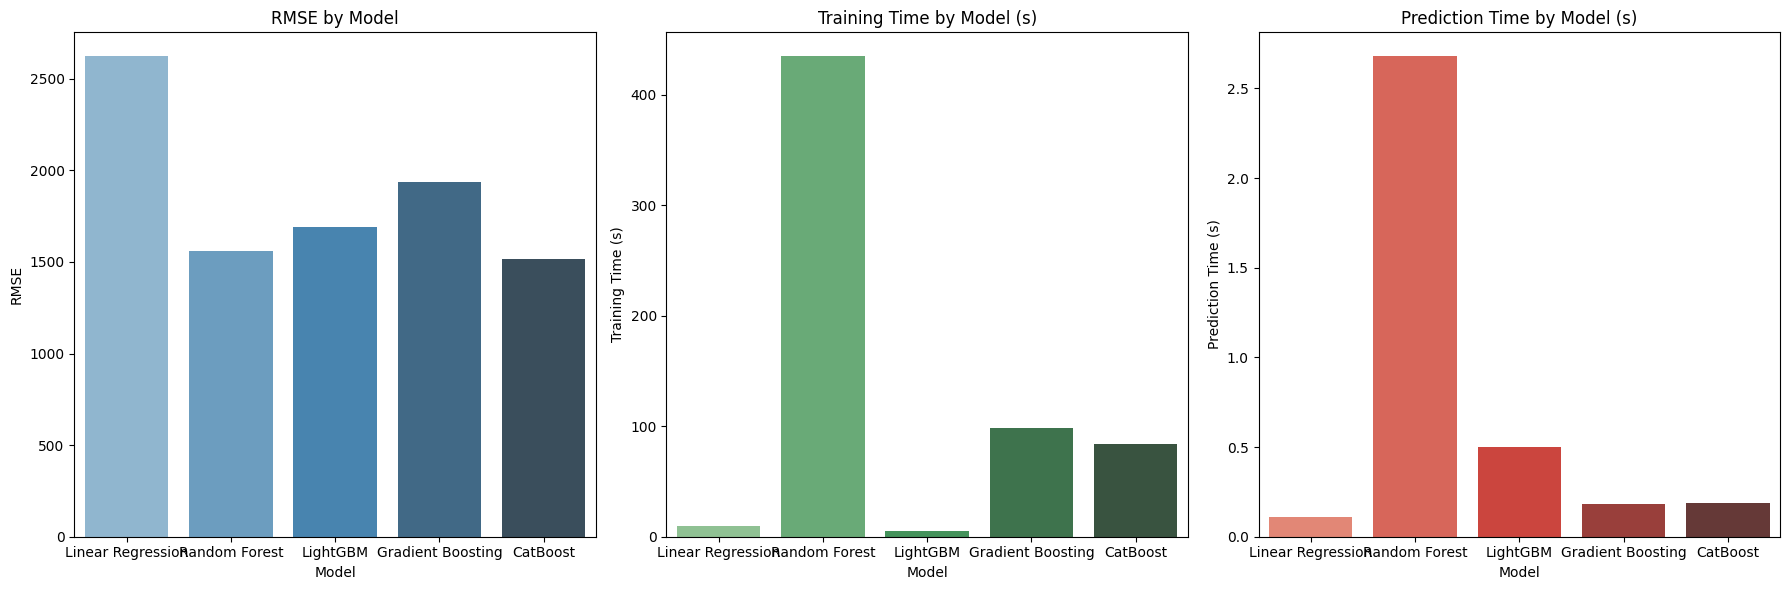

In [39]:
# Data for plotting
models = results_df['Model']
rmse = results_df['RMSE']
training_time = results_df['Training Time (s)']
prediction_time = results_df['Prediction Time (s)']


# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE Plot
sns.barplot(x=models, y=rmse, ax=axes[0], palette='Blues_d')
axes[0].set_title('RMSE by Model')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Model')

# Training Time Plot
sns.barplot(x=models, y=training_time, ax=axes[1], palette='Greens_d')
axes[1].set_title('Training Time by Model (s)')
axes[1].set_ylabel('Training Time (s)')
axes[1].set_xlabel('Model')

# Prediction Time Plot
sns.barplot(x=models, y=prediction_time, ax=axes[2], palette='Reds_d')
axes[2].set_title('Prediction Time by Model (s)')
axes[2].set_ylabel('Prediction Time (s)')
axes[2].set_xlabel('Model')

# Show the plots
plt.tight_layout()
plt.show()

## Conclusion

**Prediction Accuracy (RMSE):**
- The CatBoost model has the lowest RMSE (1516.65), followed closely by Random Forest (1560.81) and LightGBM (1691.06). This indicates that CatBoost offers the best prediction accuracy among the models.
- Linear Regression and Gradient Boosting have higher RMSE values (2622.53 and 1937.27, respectively), suggesting they are less accurate compared to other models.

**Training Efficiency (Training Time):**
- Linear Regression is by far the fastest model to train, taking only 9.65 seconds. This is significantly faster than all other models.
- LightGBM is also quite efficient, with a training time of 4.99 seconds.
- Random Forest, Gradient Boosting, and CatBoost take much longer, with Random Forest being the slowest (434.57 seconds).

**Prediction Efficiency (Prediction Time):**

- Linear Regression has the fastest prediction time (0.11 seconds), followed by CatBoost and Gradient Boosting (0.19 seconds).
- Random Forest has the slowest prediction time (2.68 seconds), which may be a consideration in time-sensitive applications.


**Based on the above analysis, CatBoost is recommended for the highest prediction accuracy, while Linear Regression offers the quickest training and prediction times if efficiency is paramount. If the trade-off between training time and accuracy is acceptable, LightGBM would also be a strong option.**

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed